In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import chess
from sarfa import core, BoardVisualization, SarfaBaseline, Engine, RemovalPerturber, SarfaComputeResult
from utils import get_all_pos
from IPython.display import Image, display
from collections import defaultdict

# Configure Test

In [ ]:
{"fen":"3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1","responseMoves":["Rxf7"],"saliencyGroundTruth":["f1","h2","c3","e1","b3","h7","g3","g7"],"solution":["Rxf7","Qxc7"]}

In [23]:
FEN = "3q1rk1/1bp2ppp/1p5r/8/8/1BP3Q1/PP4PP/4RRK1 w - - 0 1"
action = None
DISCOUNT_FACTOR = 0.9
DEPTH = 3

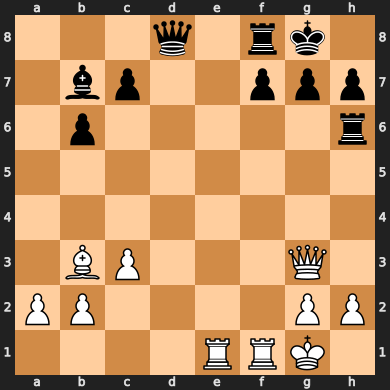

In [20]:
board = chess.Board(FEN)
board_visualization = BoardVisualization(board)
board_visualization.only_board()

# Algorithm Test

In [104]:
engine = Engine("./stockfish_15_x64_avx2")
saliency_results_per_step = []
moves_taken = []

def sequential_saliency_algorithm(fen, discount_factor, depth, runtime=2.0):
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    
    current_to_original_pos_mapping = {pos: pos for pos in get_all_pos()}

    for curr_step in range(0, depth):
        print(f"curr step: {curr_step}")
        saliency_calculator = SarfaBaseline(engine, board, runtime=runtime)
        
        optimal_move, optimal_move_q = None, 0

        for perturbed_board, perturbed_position_str in perturber.process():
            sarfa_compute_result: SarfaComputeResult = saliency_calculator.compute(perturbed_board, None)

            # update the optimal action for this depth
            # don't take an action that is coming from perturbation
            # leading to check
            if sarfa_compute_result.optimal_move_q_val != float("inf") and \
                (not optimal_move or sarfa_compute_result.optimal_move_q_val > optimal_move_q):
                optimal_move = sarfa_compute_result.optimal_move
                optimal_move_q = sarfa_compute_result.optimal_move_q_val
            
            perturbed_position_original_str = current_to_original_pos_mapping[perturbed_position_str]
            saliency_results[perturbed_position_original_str] += (sarfa_compute_result.saliency * (discount_factor ** curr_step))
        
        saliency_results_per_step.append((saliency_results.copy(), board.copy()))

        # take optimal action on the current board
        # use this new board is the action for next iteration
        optimal_move_obj = chess.Move.from_uci(optimal_move)
        moves_taken.append(optimal_move_obj)
        board.push(optimal_move_obj)

        # update mapping
        if (not board.is_game_over()):
            start_move_pos = optimal_move[0:2]
            end_move_pos = optimal_move[2:4]
            current_to_original_pos_mapping[end_move_pos] = current_to_original_pos_mapping[start_move_pos]
        else:
            print("game finished early")
            break
    
    return saliency_results

## 2 Seconds

In [105]:
saliency_results_per_step = []
moves_taken = []

saliency_results = sequential_saliency_algorithm(FEN, DISCOUNT_FACTOR, DEPTH, runtime=2.0)

curr step: 0
{'f1f7': 11.24, 'g3e5': 1.6, 'e1d1': 1.06, 'f1f2': 0.52, 'g3f4': 0.35, 'e1e2': 0.3, 'g3e3': 0.25, 'b3c2': -0.04, 'f1f4': -0.09, 'g3f2': -0.26, 'f1f5': -3.86, 'g1h1': -4.6, 'h2h3': -4.8, 'f1f3': -4.8, 'g3g4': -4.94, 'e1e5': -4.94, 'b3c4': -4.97, 'e1a1': -5.36, 'e1c1': -5.42, 'h2h4': -5.43, 'e1b1': -5.6, 'b3f7': -5.91, 'b3a4': -6.46, 'b3d1': -6.51, 'e1e3': -6.64, 'c3c4': -7.0, 'b3e6': -7.1, 'g1f2': -8.02, 'e1e4': -8.03, 'e1e6': -8.33, 'g3f3': -8.34, 'b3d5': -8.7, 'g3d3': -8.84, 'e1e7': -9.59, 'e1e8': -9.68, 'g3h3': -9.8, 'f1f6': -10.03, 'g3g7': -10.46, 'g3h4': -10.73, 'g3g6': -11.01, 'g3g5': -11.87, 'g3c7': -12.09, 'g3d6': -14.13}
optimal action: f1f7
before:	{'f1f7': 11.24, 'g3e5': 1.6, 'e1d1': 1.06, 'f1f2': 0.52, 'g3f4': 0.35, 'e1e2': 0.3, 'g3e3': 0.25, 'b3c2': -0.04, 'f1f4': -0.09, 'g3f2': -0.26, 'f1f5': -3.86, 'g1h1': -4.6, 'h2h3': -4.8, 'f1f3': -4.8, 'g3g4': -4.94, 'e1e5': -4.94, 'b3c4': -4.97, 'e1a1': -5.36, 'e1c1': -5.42, 'h2h4': -5.43, 'e1b1': -5.6, 'b3f7': -5.91, 'b

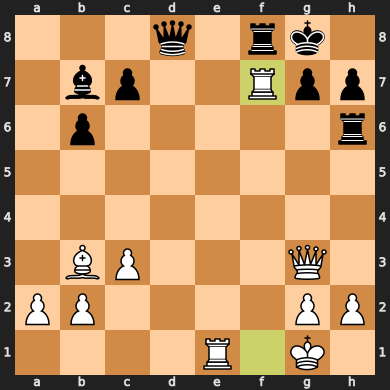

In [101]:
board

In [65]:
board = saliency_results_per_step[1][1]
options = engine.q_values(board, board.legal_moves)
options

PovScore(Cp(-951), BLACK) -951 +951 -951
PovScore(Cp(-959), BLACK) -959 +959 -959
PovScore(Mate(-7), BLACK) #-7 #+7 #-7


({'g8h8': 0,
  'f8e8': 0,
  'f8f7': -9.59,
  'd8e8': 0,
  'd8c8': 0,
  'd8b8': 0,
  'd8a8': 0,
  'd8e7': 0,
  'd8d7': 0,
  'd8f6': 0,
  'd8d6': 0,
  'd8g5': 0,
  'd8d5': 0,
  'd8h4': 0,
  'd8d4': 0,
  'd8d3': 0,
  'd8d2': 0,
  'd8d1': 0,
  'b7c8': 0,
  'b7a8': 0,
  'b7c6': 0,
  'b7a6': 0,
  'b7d5': 0,
  'b7e4': 0,
  'b7f3': 0,
  'b7g2': 0,
  'h6g6': -9.51,
  'h6f6': 0,
  'h6e6': 0,
  'h6d6': 0,
  'h6c6': 0,
  'h6h5': 0,
  'h6h4': 0,
  'h6h3': 0,
  'h6h2': 0,
  'g7g6': 0,
  'c7c6': 0,
  'b6b5': 0,
  'g7g5': -40,
  'c7c5': 0},
 'g8h8')

Important: 
["f1","h2","c3","e1","b3","h7","g3","g7"]

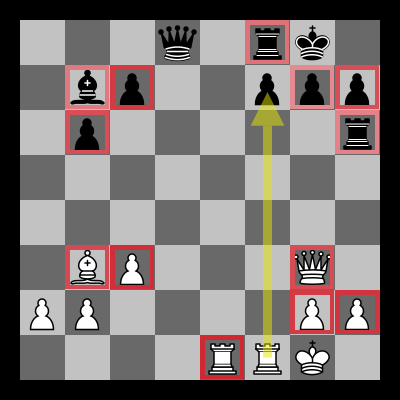

In [102]:
board_visualization = BoardVisualization(chess.Board(FEN))
path = board_visualization.show_heatmap(saliency_results, moves_taken[0])
display(Image(path))

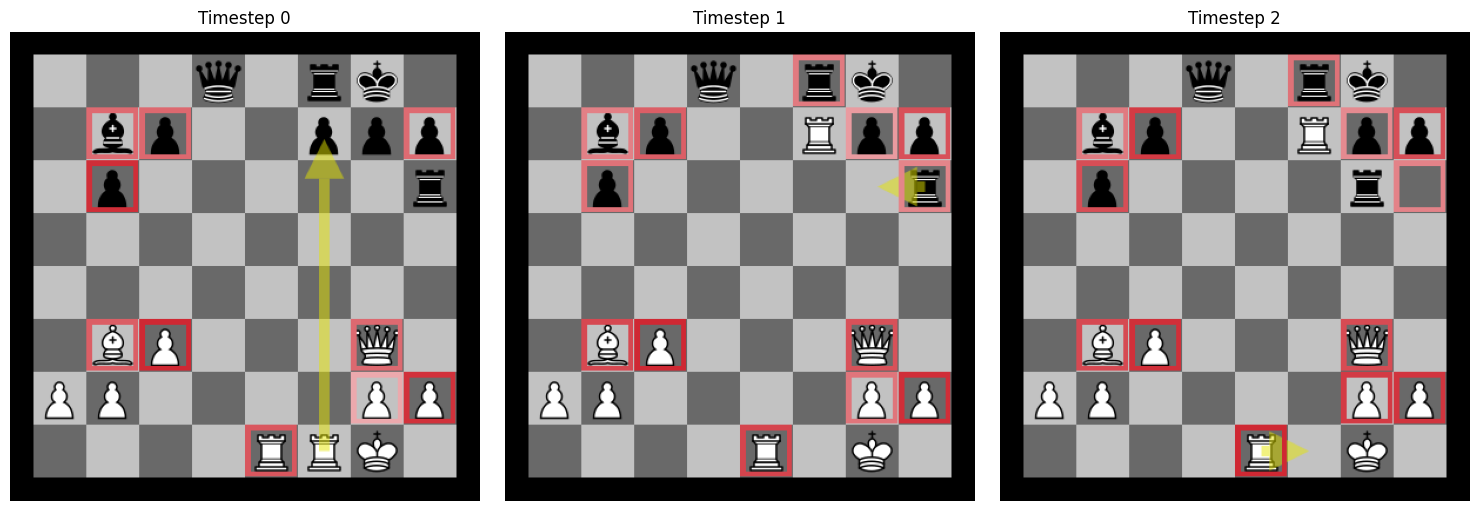

In [103]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Create a grid of subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, depth, figsize=(15, 5))  # Adjust the size as needed

# Loop through indices 1 through 3
for step in range(depth):  # 1 through 3 inclusive
    board_visualization = BoardVisualization(saliency_results_per_step[step][1])
    path = board_visualization.show_heatmap(saliency_results_per_step[step][0], moves_taken[step])
    img = PILImage.open(path)
    
    # Display the image in the corresponding subplot
    axes[step].imshow(img)
    axes[step].axis('off')  # Turn off axis
    axes[step].set_title(f"Timestep {step}", fontsize=12)

# Adjust layout and show the grid
plt.tight_layout()
plt.show()


## 4 Seconds

In [36]:
saliency_results_per_step = []
moves_taken = []

saliency_results = sequential_saliency_algorithm(FEN, DISCOUNT_FACTOR, DEPTH, runtime=4.0)

curr step: 0
curr step: 1
curr step: 2


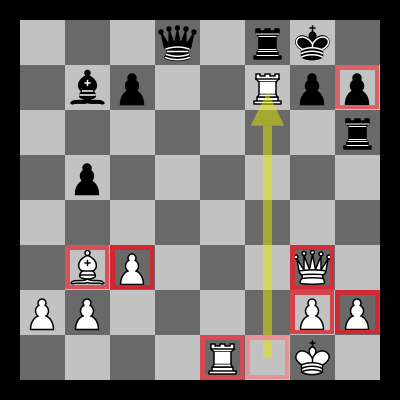

In [37]:
board_visualization = BoardVisualization(FEN)
path = board_visualization.show_heatmap(saliency_results, moves_taken[0])
display(Image(path))

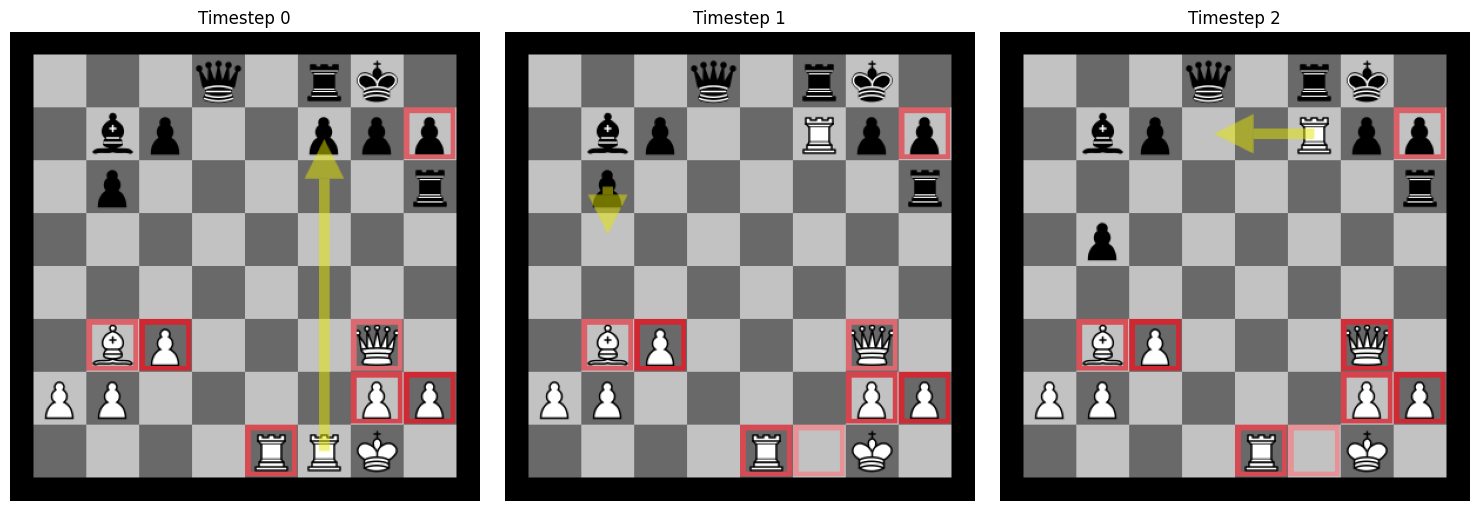

In [38]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Create a grid of subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, depth, figsize=(15, 5))  # Adjust the size as needed

# Loop through indices 1 through 3
for step in range(depth):  # 1 through 3 inclusive
    board_visualization = BoardVisualization(saliency_results_per_step[step][1])
    path = board_visualization.show_heatmap(saliency_results_per_step[step][0], moves_taken[step])
    img = PILImage.open(path)
    
    # Display the image in the corresponding subplot
    axes[step].imshow(img)
    axes[step].axis('off')  # Turn off axis
    axes[step].set_title(f"Timestep {step}", fontsize=12)

# Adjust layout and show the grid
plt.tight_layout()
plt.show()


# Benchmark

In [32]:
from chess_dataset import SafraBenchmark
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [29]:
sequential_benchmark_function = lambda x, _: sequential_saliency_algorithm(x, DISCOUNT_FACTOR, DEPTH, 2.0)
benchmark = SafraBenchmark(sequential_benchmark_function, sanity_check=True)

curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
curr step: 0
curr step: 1
curr step: 2
game finished early


In [30]:
benchmark.accuracy()

{'accuracy - harmonic_mean': 0.7149651075498575}

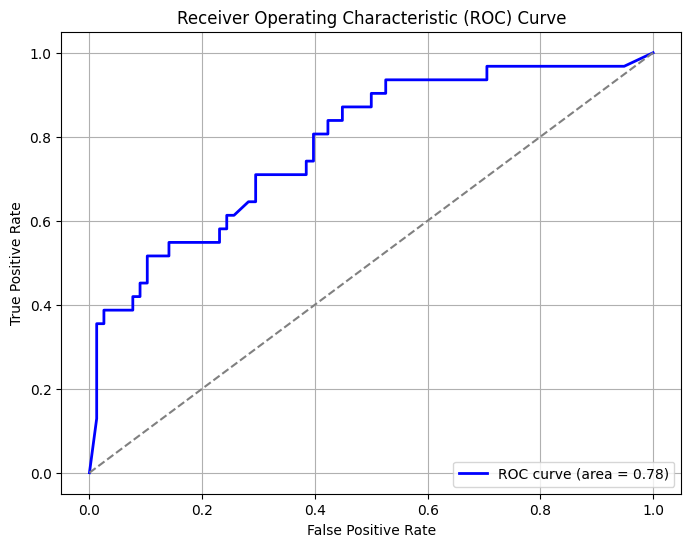

In [33]:
fpr, tpr = benchmark.roc_curve()
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()